In [1]:
# input: manual-periodogram
# output: ebai-estimates

import phoebe
from phoebe import u, c

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: TimeoutError timed out


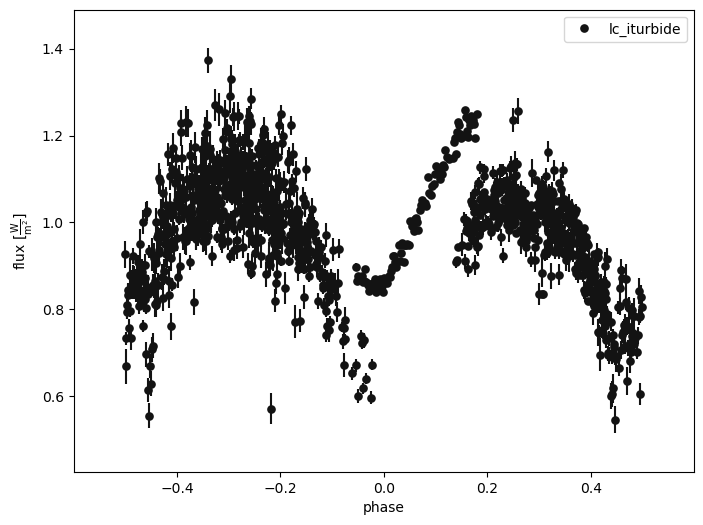

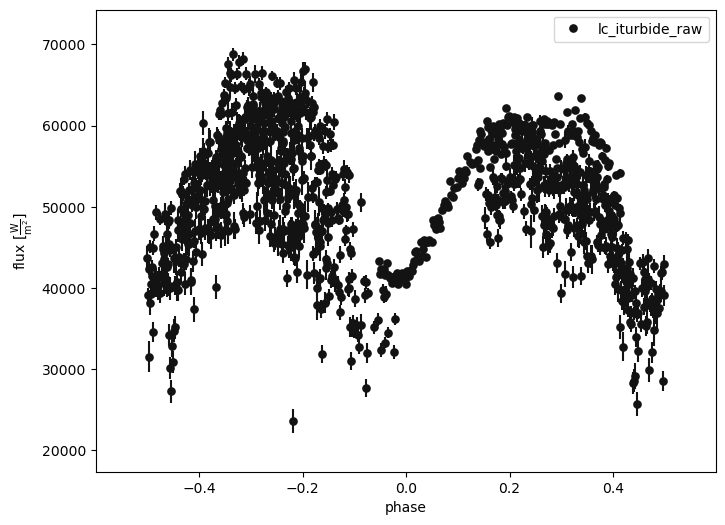

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [18]:
# b = phoebe.load("./bundle-saves/manual-periodogram")
# b = phoebe.load("./bundle-saves/aviles-data/manual-periodogram")
b = phoebe.load("./bundle-saves/comp-LID3/manual-periodogram")
gen_utils.resetAtmosphere(b)
b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True, marker='.')
b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

In [19]:
gaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' not in d]
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]
gaiaDatasets, rawGaiaDatasets

(['lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp'],
 ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw'])

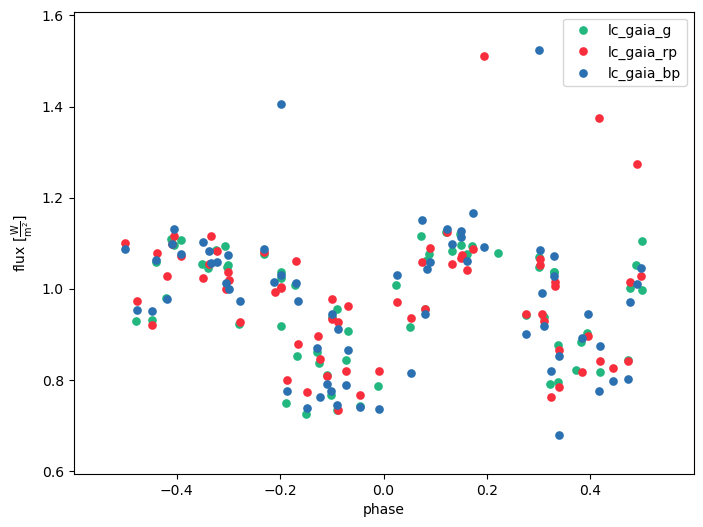

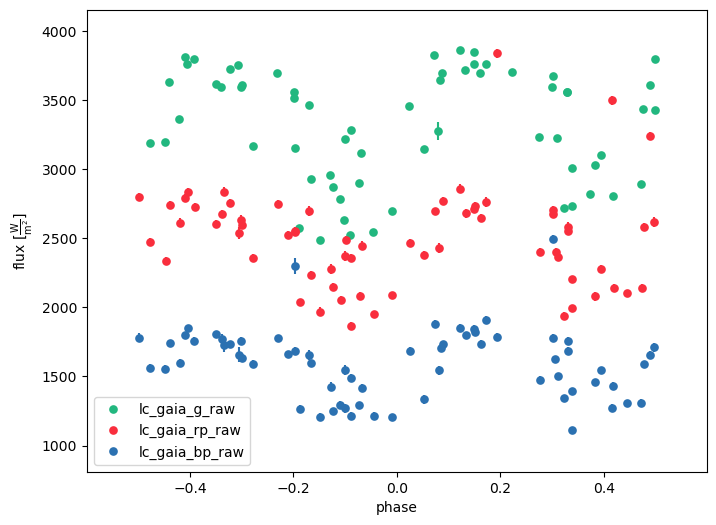

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [20]:
b.plot(x='phase', dataset=gaiaDatasets, show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)
b.plot(x='phase', dataset=rawGaiaDatasets, show=True, legend=True, marker='.', color=gen_utils.GAIA_RAW_PLOT_COLORS)

### Default forward models

In [21]:
# EBAI KNN values all seem to affect relative values
    # setting to dataset-scaled to see if at least general shape of model is correct
    # might also help with getting a good trend out of residuals when adopting estimator solutions
b.set_value_all(qualifier='pblum_mode', value='dataset-scaled')

# will probably use this strategy when optimizing; will try to optimize for pblum
# for d in b.datasets:
#     if "raw" in d:
#         b.set_value(qualifier='pblum_mode', dataset=d, value='absolute')
# print(b['pblum_mode'])

5744.8833816185825
Parameter: teff@primary@component
                       Qualifier: teff
                     Description: Mean effective temperature
                           Value: 6000.0 K
                  Constrained by: 
                      Constrains: teffratio@binary@component
                      Related to: teff@secondary@component, teffratio@binary@component



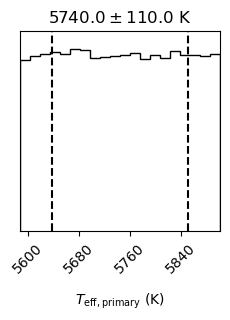

In [22]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
centralTeff = 6951.42*b.get_value(qualifier='period', component='binary') + 3426.01
print(centralTeff)
print(b['teff@primary'])

b.add_distribution(qualifier='teff', component='primary',
				   value=phoebe.uniform(high=centralTeff + 156.28, low=centralTeff - 156.58, unit=u.K),
				   distribution='poro_porb_bounds', overwrite_all=True)
_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

In [29]:
%%script echo "ignore distance set for now"
distance = 1000 / 0.38051966554433253 # GDR3 parallax, in mas (1000)

b.set_value(qualifier='distance', value=distance*u.pc)
print(distance, "pc")
print(b['distance'])

ignore distance set for now


In [30]:
%%script echo "skipping default model for normalized datasets"

gen_utils.abilitateDatasets(b, ['lc_iturbide'] + gaiaDatasets)
b.run_compute(compute='phoebe01', model='full_default', overwrite=True)

b.plot(x='phase', dataset=['lc_iturbide'] + gaiaDatasets, model='full_default', show=True, legend=True, marker={'dataset': '.'})
b.plot(['model'], x='phase', dataset=['lc_iturbide'] + gaiaDatasets, model='full_default', show=True, legend=True, marker={'dataset': '.'})

skipping default model for normalized datasets


In [23]:
allRawDatasets = ['lc_iturbide_raw'] + rawGaiaDatasets
gen_utils.abilitateDatasets(b, allRawDatasets)

In [25]:
b.distributions

['poro_porb_bounds']

Fri, 06 Oct 2023 17:44 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [02:13<00:00, 10.59it/s]


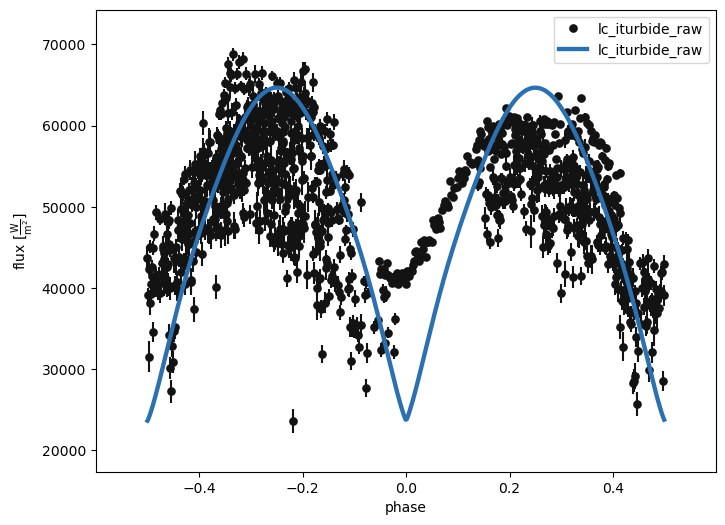

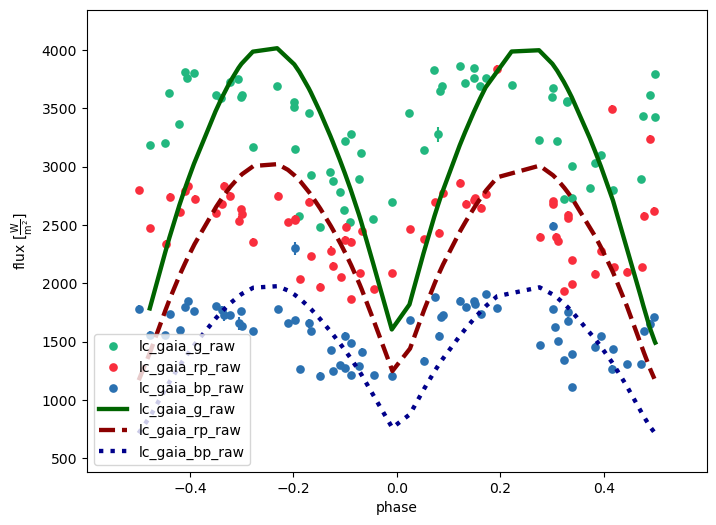

(<autofig.figure.Figure | 1 axes | 6 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [24]:
b.run_compute(compute='phoebe01', model='raw_model', overwrite=True)
b.plot(x='phase', dataset='lc_iturbide_raw', kind='lc', show=True, legend=True, marker={'dataset': '.'})
b.plot(x='phase', dataset=rawGaiaDatasets, kind='lc', show=True, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

Fri, 06 Oct 2023 17:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
  0%|          | 0/5 [00:00<?, ?it/s]Fri, 06 Oct 2023 17:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Fri, 06 Oct 2023 17:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Fri, 06 Oct 2023 17:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Fri, 06 Oct 2023 17:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Fri

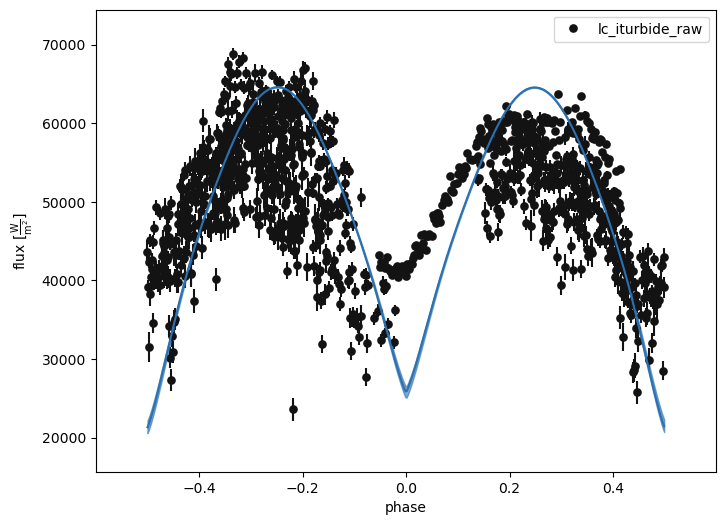

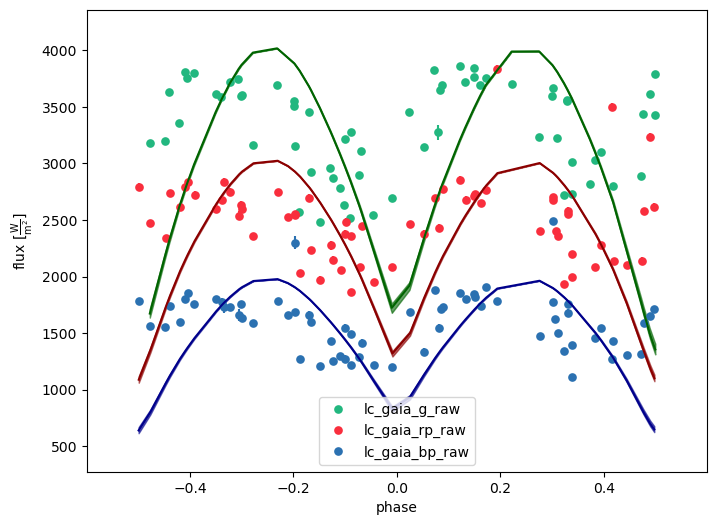

(<autofig.figure.Figure | 1 axes | 6 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [26]:
b.run_compute(compute='phoebe01', model='init_dist_model', sample_from='poro_porb_bounds', sample_num=5, overwrite=True)
b.plot(x='phase', model='init_dist_model', dataset='lc_iturbide_raw', kind='lc', show=True, legend=True, marker={'dataset': '.'})
b.plot(x='phase', model='init_dist_model', dataset=rawGaiaDatasets, kind='lc', show=True, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

## EBAI KNN estimator runs

In [6]:
# ignore sklearn warnings; caused by PHOEBE internals
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Normalized datasets

In [12]:
# %%script echo "skipping normalized datasets"
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn', lc_datasets=['lc_iturbide'] + gaiaDatasets, overwrite=True)
print(b['ebai_knn'])

b.run_solver(solver='ebai_knn', solution='ebai_knn_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_solution')
print()
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_solution', {'incl@binary@orbit@component': u.rad})

ParameterSet: 7 parameters
         comments@ebai_knn@solver: 
       use_server@ebai_knn@solver: none
      lc_datasets@ebai_knn@solver: ['lc_iturbide', 'lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp']
       lc_combine@ebai_knn@solver: median
        phase_bin@ebai_knn@solver: False
      ebai_method@ebai_knn@solver: knn
            orbit@ebai_knn@solver: binary


Mon, 18 Sep 2023 18:08 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Mon, 18 Sep 2023 18:08 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


t0_supconj@binary@orbit@component = 0.14901 d
teffratio@binary@orbit@component = 0.91419 
incl@binary@orbit@component = 1.10287 rad
fillout_factor@contact_envelope@envelope@component = 0.29972 
q@binary@orbit@component = 0.83674 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 1.5707963267948966 rad
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [81]:
%%script echo "skipping normalized datasets"

# individual normalized dataset estimations

normalizedDatasets = ['lc_iturbide'] + gaiaDatasets
for d in normalizedDatasets:
	print(f"\nf'ebai_knn_{d}_solution'\n----------------------------------")
	b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver=f'ebai_knn_{d}', lc_datasets=[d], overwrite=True)
	b.run_solver(solver=f'ebai_knn_{d}', solution=f'ebai_knn_{d}_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_knn_{d}_solution')

skipping normalized datasets


In [16]:
# all normalized Gaia datasets

b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_gaia', lc_datasets=gaiaDatasets, overwrite=True)
try:
	b.run_solver(solver='ebai_knn_gaia', solution='ebai_knn_gaia_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'ebai_knn_gaia_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_gaia_solution', {'incl@binary': u.rad})
except TypeError:
	print("Failed to generate estimation for normalized Gaia data")

t0_supconj@binary@orbit@component = -0.04982 d
teffratio@binary@orbit@component = 0.72972 
incl@binary@orbit@component = 0.87683 rad
fillout_factor@contact_envelope@envelope@component = 0.66889 
q@binary@orbit@component = 4.28466 

  t0_supconj@binary@orbit@component 0.0 d
  teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 90.0 deg
  fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


### Raw datasets

In [7]:
# for d in allRawDatasets:
for d in ['lc_iturbide_raw']:
	print(f"\nf'ebai_knn_{d}_solution'\n----------------------------------")
	b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver=f'ebai_knn_{d}', lc_datasets=[d], overwrite=True)
	try:
		b.run_solver(solver=f'ebai_knn_{d}', solution=f'ebai_knn_{d}_solution', overwrite=True)
	except:
		print(f"Couldn't generate an estimator result using {d}")
		continue
	gen_utils.printFittedVals(b, f'ebai_knn_{d}_solution')


f'ebai_knn_lc_iturbide_raw_solution'
----------------------------------
2G model CG failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
2G model CG12 failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
2G model CG12E1 failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Couldn't generate an estimator result using lc_iturbide_raw


In [17]:
# all raw datasets

b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_raw', lc_datasets=allRawDatasets, overwrite=True)
b.run_solver(solver='ebai_knn_raw', solution='ebai_knn_raw_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_raw_solution')

2G model CG failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
2G model CG12E1 failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
2G model CG12E2 failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.


TypeError: TwoGaussianModel.cg() missing 3 required positional arguments: 'mu', 'd', and 'sigma'

In [13]:
# raw Gaia datasets

b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_raw_gaia', lc_datasets=rawGaiaDatasets, overwrite=True)
b.run_solver(solver='ebai_knn_raw_gaia', solution='ebai_knn_raw_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_raw_gaia_solution')

t0_supconj@binary@orbit@component = -0.04982 d
teffratio@binary@orbit@component = 0.97366 
incl@binary@orbit@component = 1.24114 rad
fillout_factor@contact_envelope@envelope@component = 0.24588 
q@binary@orbit@component = 7.97975 


In [86]:
%%script echo "skipping printing normalized solution"
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_solution', {'incl@binary@orbit@component': u.rad})

skipping printing normalized solution


In [18]:
print(b['teffratio'])
print(b['fillout_factor'])
print(b['teff'])

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 1.0
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@secondary@component, teff@primary@component

Parameter: fillout_factor@contact_envelope@component
                       Qualifier: fillout_factor
                     Description: Fillout-factor of the envelope
                           Value: 0.6417897080770951
                  Constrained by: 
                      Constrains: pot@contact_envelope@component
                      Related to: q@binary@component, pot@contact_envelope@component

ParameterSet: 3 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 6000.0 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}


In [14]:
b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

## Testing fit of each solution

### Temporary back up
Storing the original bundle results in memory, in case need to revert arises

In [19]:
backupBundle = b.copy()

In [90]:
%%script echo "skipping; comment this out if we need to reset to previous state"
b = backupBundle.copy()

skipping; comment this out if we need to reset to previous state


In [20]:
b.solutions, b.solvers

(['lcperiod_iturbide_auto_solution',
  'lcperiod_iturbide_manual_solution',
  'ebai_knn_solution',
  'ebai_knn_raw_gaia_solution',
  'ebai_knn_gaia_solution'],
 ['lcperiod_iturbide_auto',
  'lcperiod_iturbide_manual',
  'ebai_knn_lc_iturbide_raw',
  'ebai_knn',
  'ebai_knn_raw_gaia',
  'ebai_knn_gaia',
  'ebai_knn_raw'])

### Checking solution goodness of fit

In [21]:
# b.set_value_all(qualifier='enabled', value=True)

# using only raw datasets right now
gen_utils.abilitateDatasets(b, allRawDatasets)

print(b['enabled'])

ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide@phoebe0...: False
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True


In [93]:
print(b['requiv'])
print(b['sma@binary'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.5 solRad
C      requiv@secondary@component: 1.4999999999999996 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
Parameter: sma@binary@component
                       Qualifier: sma
                     Description: Semi-major axis of the orbit (defined at time t0@system)
                           Value: 3.35 solRad
                  Constrained by: 
                      Constrains: asini@binary@component, requiv@secondary@component, requivratio@binary@component, requivsumfrac@binary@component, mass@primary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@seconda

In [41]:
b.set_value(qualifier='ntriangles', value=4000) # originally 3000
print(b['ntriangles'])

Parameter: ntriangles@contact_envelope@phoebe01@compute
                       Qualifier: ntriangles
                     Description: Requested number of triangles (won't be exact).
                           Value: 4000
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: mesh_method:marching,hierarchy.is_meshable:true



ebai_knn_lc_iturbide_raw_solution not found
ebai_knn_solution ebai_knn_model
-------------------------------
t0_supconj@binary@orbit@component = 0.14901 d
teffratio@binary@orbit@component = 0.91419 
incl@binary@orbit@component = 1.10287 rad
fillout_factor@contact_envelope@envelope@component = 0.29972 
q@binary@orbit@component = 0.83674 
Total residuals
	 lc_iturbide_raw -1777709.2391407033 W / m2
	 lc_gaia_g_raw 1728.6557276084231 W / m2
	 lc_gaia_rp_raw 2044.622744407383 W / m2
	 lc_gaia_bp_raw 1362.3909600117279 W / m2


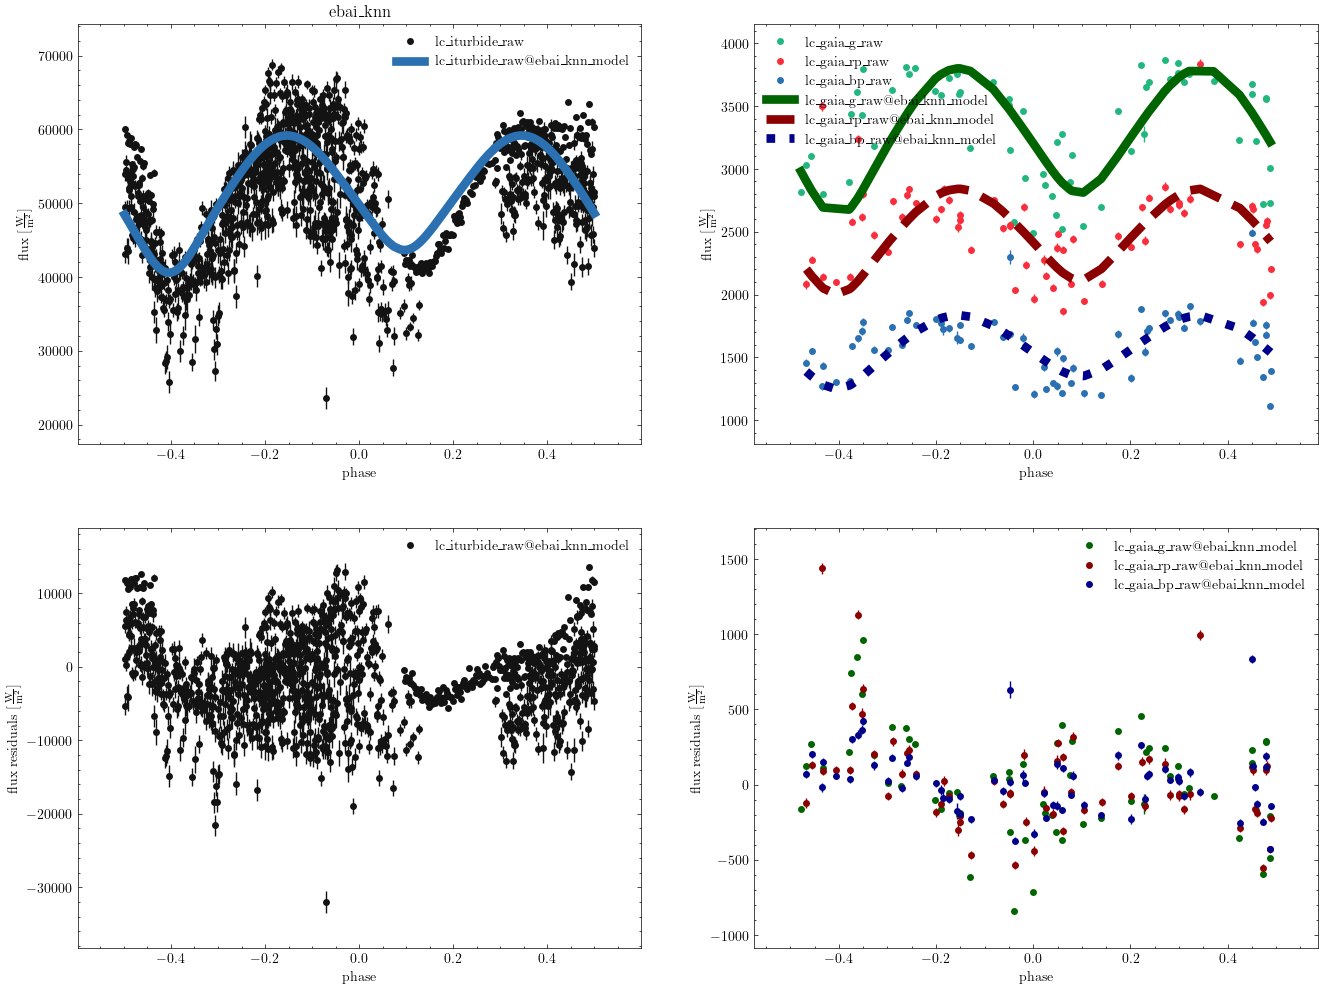

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_gaia_solution ebai_knn_raw_gaia_model
-------------------------------
t0_supconj@binary@orbit@component = -0.04982 d
teffratio@binary@orbit@component = 0.97366 
incl@binary@orbit@component = 1.24114 rad
fillout_factor@contact_envelope@envelope@component = 0.24588 
q@binary@orbit@component = 7.97975 
Total residuals
	 lc_iturbide_raw -109734.42813455773 W / m2
	 lc_gaia_g_raw 988.4966180636638 W / m2
	 lc_gaia_rp_raw 1961.2624532973105 W / m2
	 lc_gaia_bp_raw 1618.6086052554083 W / m2


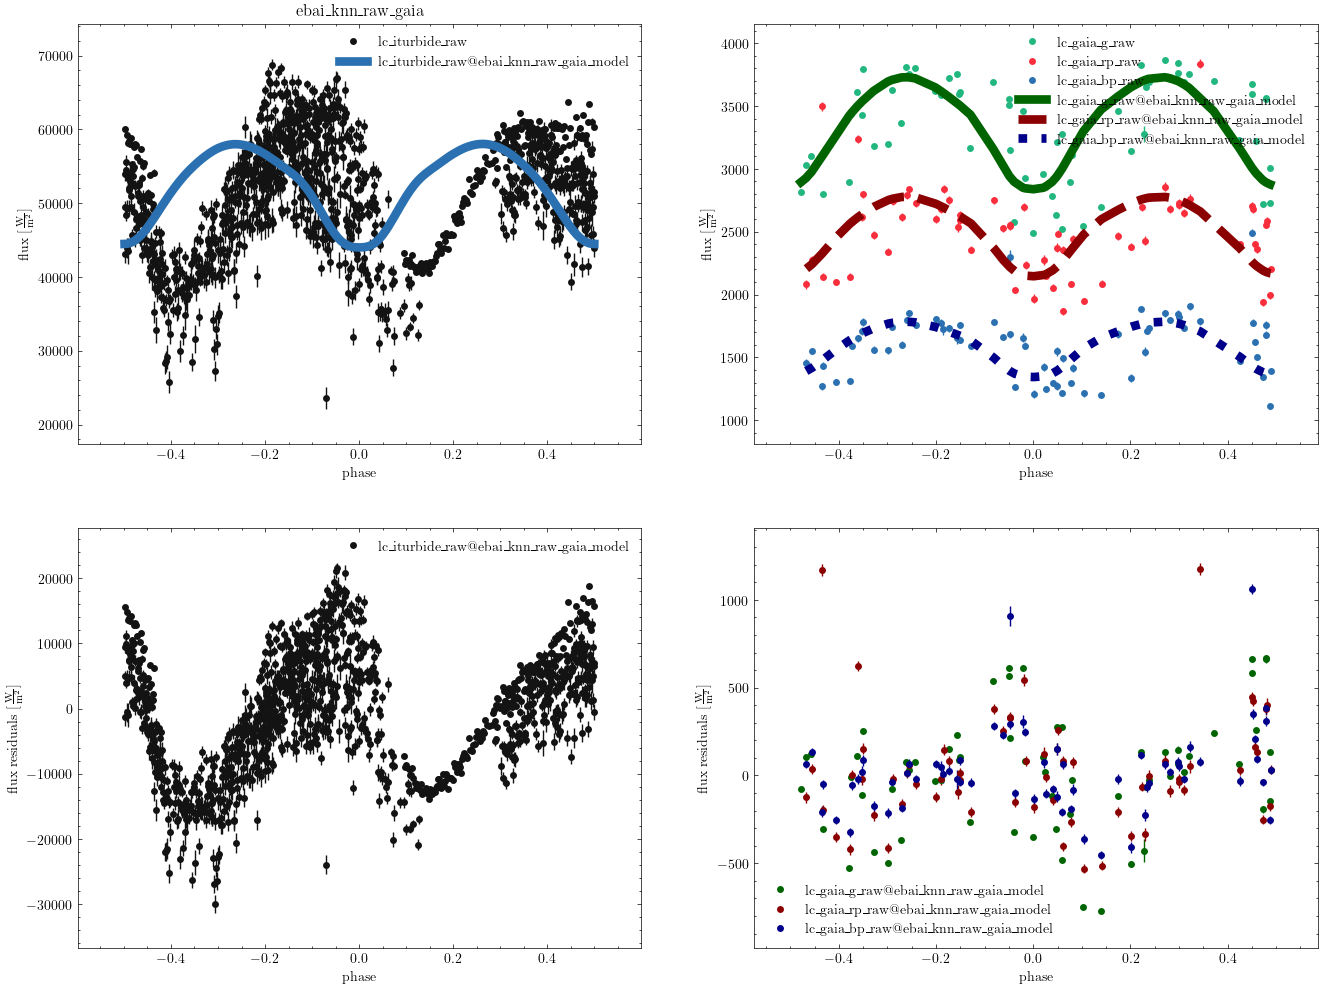

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_gaia_solution ebai_knn_gaia_model
-------------------------------
t0_supconj@binary@orbit@component = -0.04982 d
teffratio@binary@orbit@component = 0.72972 
incl@binary@orbit@component = 0.87683 rad
fillout_factor@contact_envelope@envelope@component = 0.66889 
q@binary@orbit@component = 4.28466 
Total residuals
	 lc_iturbide_raw -39776.497433760436 W / m2
	 lc_gaia_g_raw 1987.7319423135978 W / m2
	 lc_gaia_rp_raw 1804.8617091563076 W / m2
	 lc_gaia_bp_raw 1817.189184026539 W / m2


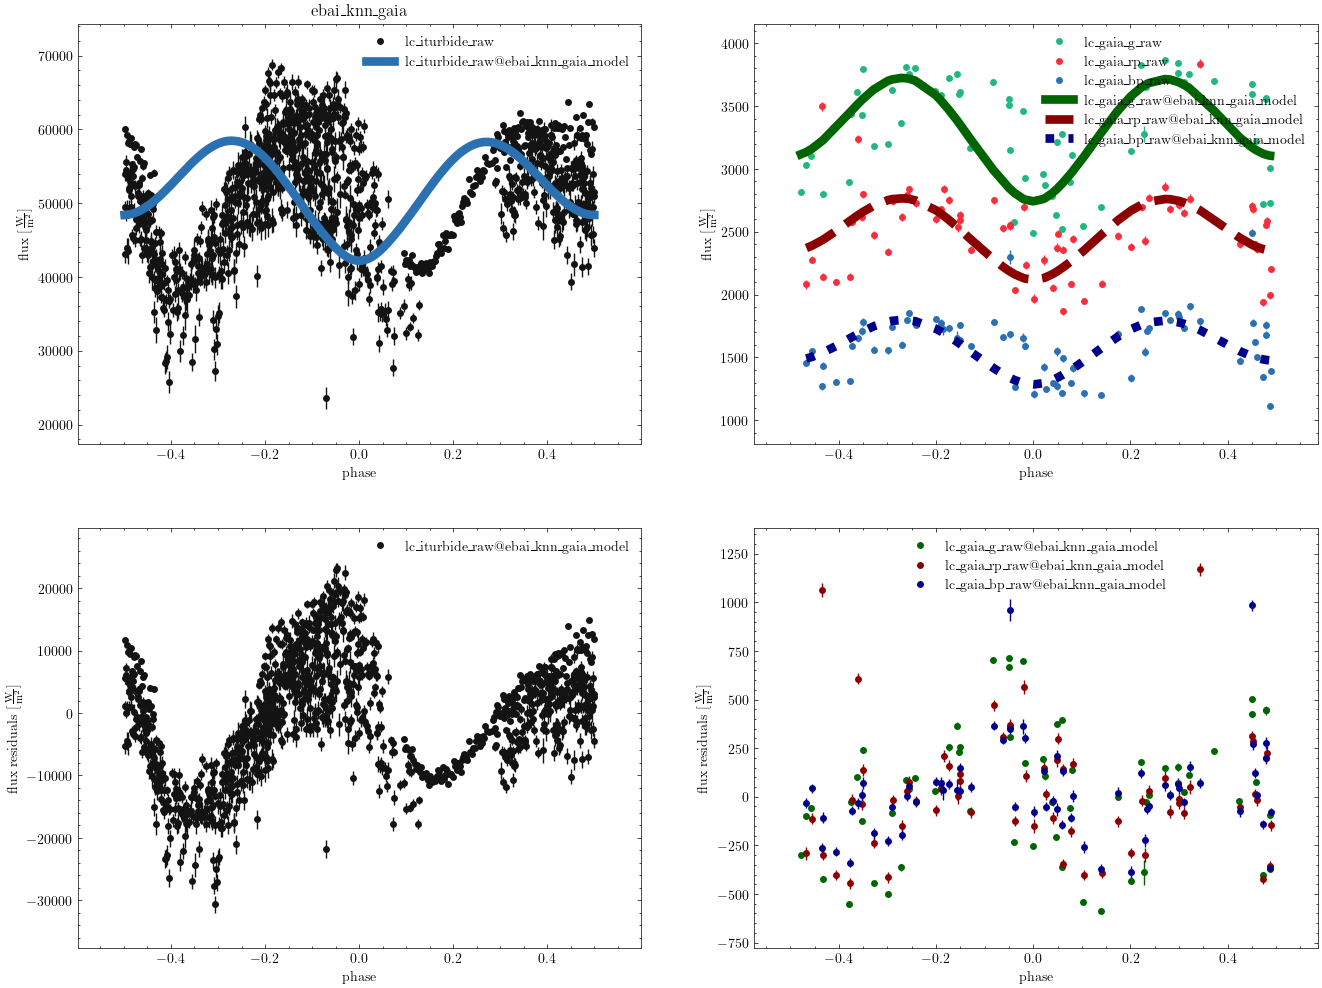

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_solution not found


In [26]:
PLOT_MODELS = True
ANIMATE = True
SAVE_PLOTS = False

for solver in [s for s in b.solvers if 'ebai_knn' in s]:
	solution = f"{solver}_solution"
	model = f"{solver}_model"

	# skipping any failed solvers
	if solution not in b.solutions:
		print(f"{solution} not found")
		continue
	print(solution, model)
	print("-------------------------------")
	gen_utils.printFittedVals(b, solution)

	if model not in b.models:
		try:
			b.adopt_solution(solution=solution)
			b.run_compute(model=model, compute='phoebe01', overwrite=True)
		except Exception as e:
			print(f"Failed to run {model} compute", e)
			continue

	print("Total residuals")

	# for all datasets, including normalized ones
	# for d in b.datasets:
	# 	if d == 'mesh01':
	# 		continue
	# 	print("\t", d, np.sum(b.calculate_residuals(model=model, dataset=d)))

	for d in allRawDatasets:
		print("\t", d, np.sum(b.calculate_residuals(model=model, dataset=d)))

	# b.plot(x='phase', model=model, dataset=normalizedDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=1)
	# b.plot(x='phase', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, title=solver, axorder=2)
	# b.plot(x='phase', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=3)

	# b.plot(x='phase', y='residuals', model=model, dataset=normalizedDatasets, kind='lc', legend=True, marker='.', s=0.008, axorder=4)
	# b.plot(x='phase', y='residuals', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker='.', s=0.008, axorder=5)
	# b.plot(x='phase', y='residuals', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, show=True, marker='.', s=0.008, draw_title=True, axorder=6, subplot_grid=(3,3), save=f"./graphs/ebai/{solver}")

	if PLOT_MODELS:
		# only including the raw datasets for this run
		b.plot(x='phase', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, title=solver, axorder=1)
		b.plot(x='phase', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=2, color=gen_utils.GAIA_RAW_PLOT_COLORS)

		b.plot(x='phase', y='residuals', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker='.', s=0.008, axorder=3)
		b.plot(x='phase', y='residuals', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, show=True, marker='.', s=0.008, draw_title=True, axorder=4, subplot_grid=(2,2), save=f"./graphs/raw_only/ebai/{solver}" if SAVE_PLOTS else None, color=gen_utils.GAIA_RAW_PLOT_COLORS)

		if ANIMATE:
			gen_utils.displayAnims(1, 3, 
					gen_utils.genAnimatedMesh(b, logger, model=model, draw_title=True, title=model, save=f"./graphs/raw_only/anims/{solver}.gif" if SAVE_PLOTS else None),
					gen_utils.genAnimatedMesh(b, logger, model=model, component='primary', draw_title=True, title=f"{model} - Primary"),
					gen_utils.genAnimatedMesh(b, logger, model=model, component='secondary', draw_title=True, title=f"{model} - Secondary"))

In [96]:
%%script echo "skipping normalized datasets for now"
modelsUsed = [m for m in b.models if 'ebai_knn' in m]
barWidth = 0.2
multiplier = 0

_, ax = plt.subplots(figsize=(20, 20))

for d in normalizedDatasets:
	if d == 'mesh01':
		continue

	modelResiduals = {}
	for m in modelsUsed:
		modelResiduals[m] = np.sum(b.calculate_residuals(model=m, dataset=d))
	residualValues = list(map(lambda r: r.value, modelResiduals.values()))
	offset = barWidth * multiplier
	xpos = np.arange(len(modelsUsed)) + offset
	rects = ax.bar(xpos, residualValues, barWidth, label=d)
	ax.bar_label(rects, padding=3, rotation=90)
	multiplier += 1

ax.set_xticks(np.arange(len(modelsUsed)), modelsUsed, rotation=70)
ax.set_title("Normalized datasets residuals")

plt.legend()
plt.show()

skipping normalized datasets for now


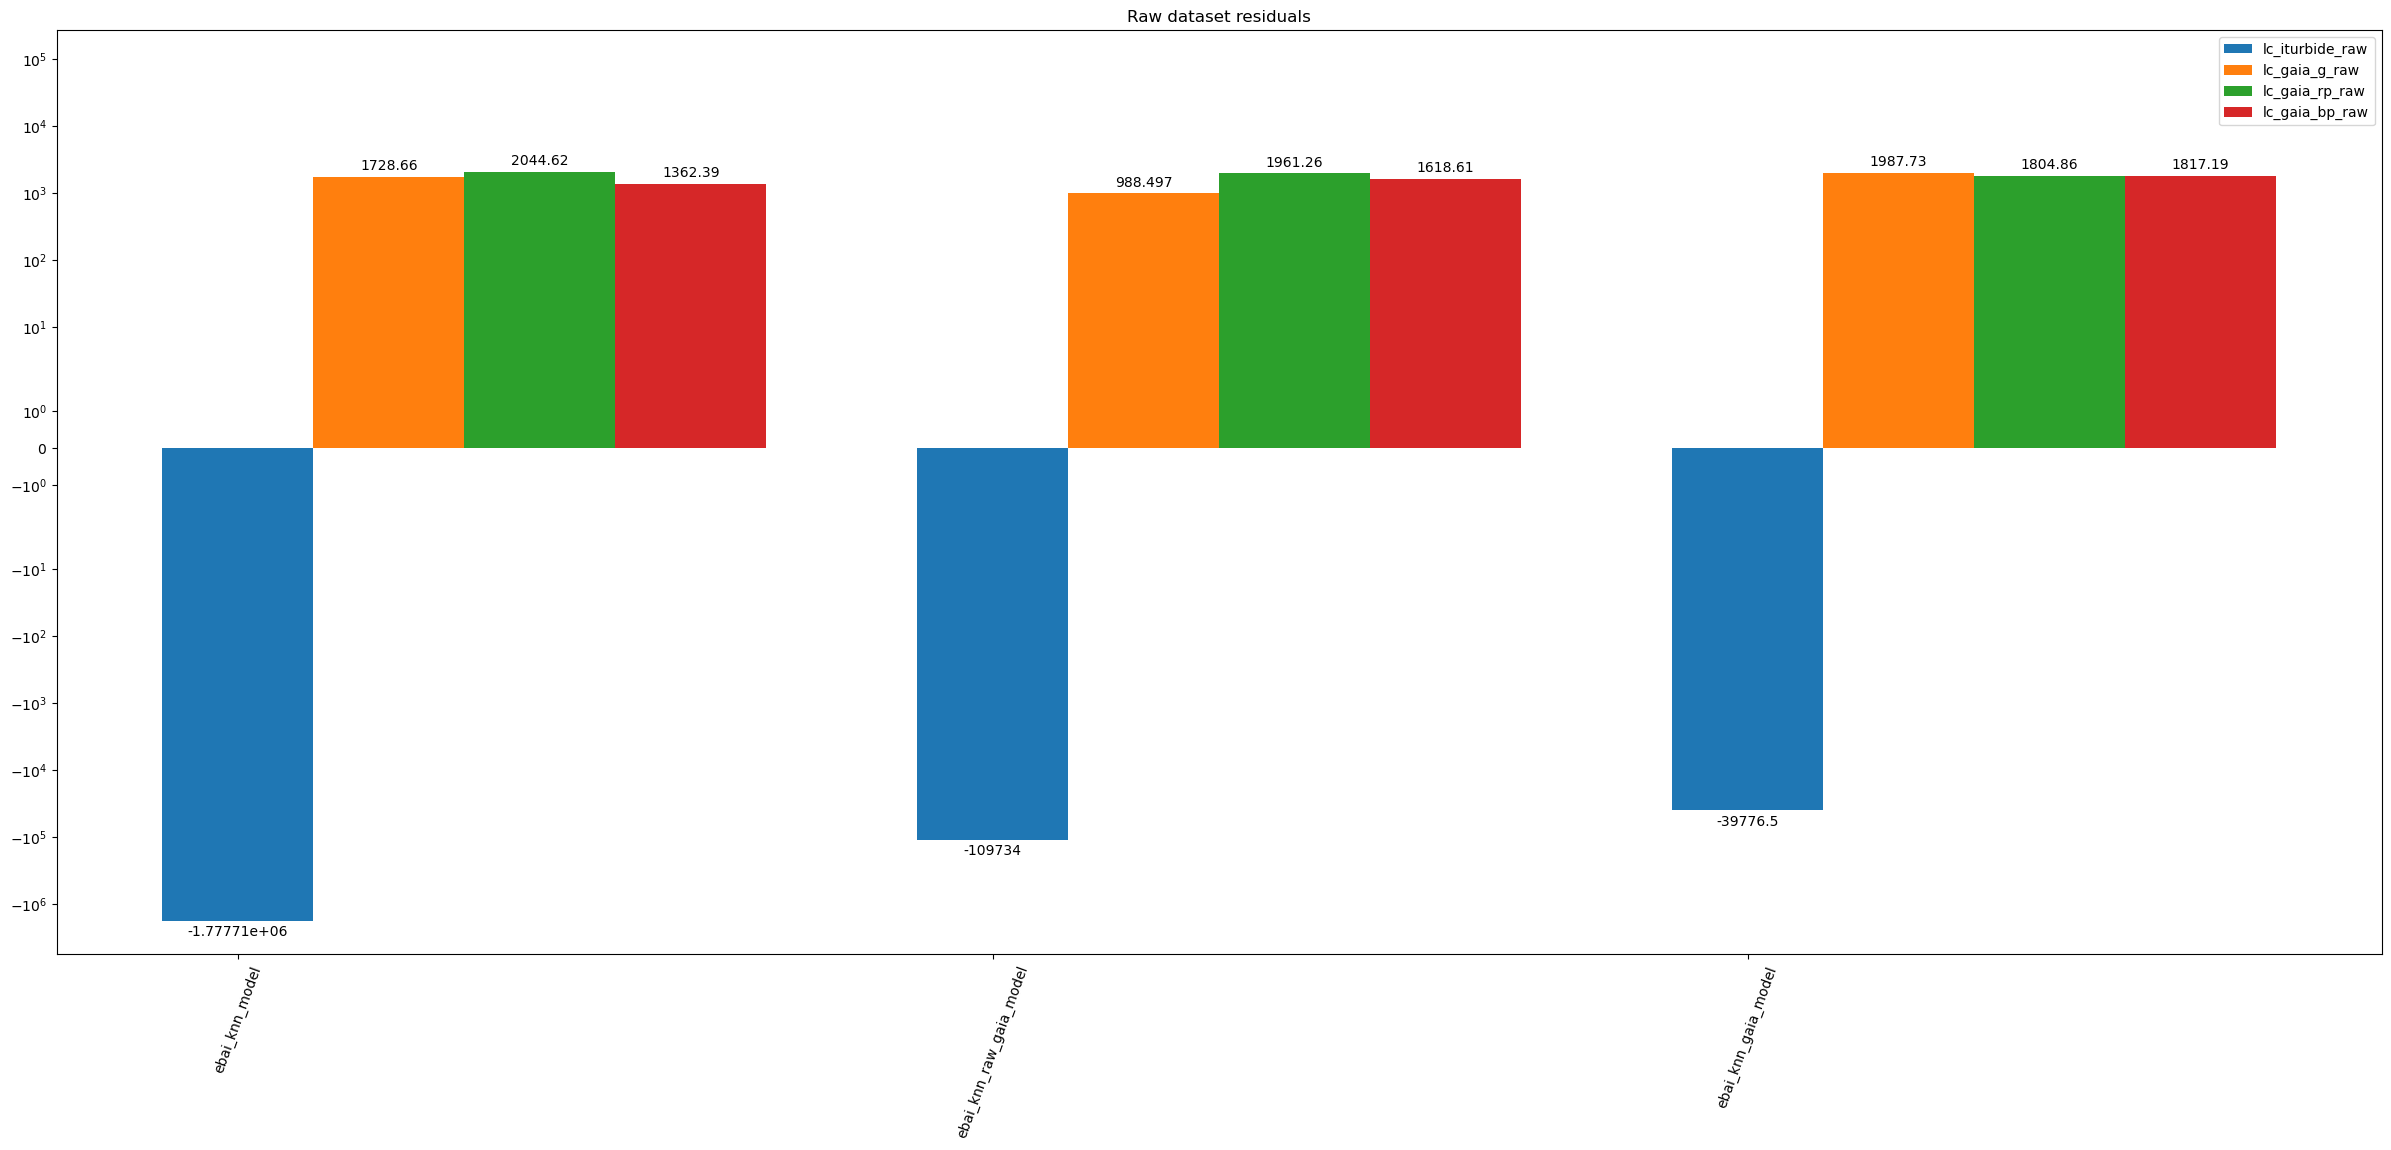

In [23]:
modelsUsed = [m for m in b.models if 'ebai_knn' in m]
barWidth = 0.2
multiplier = 0

_, ax = plt.subplots(figsize=(30, 12))

for d in allRawDatasets:
	if d == 'mesh01':
		continue

	modelResiduals = {}
	for m in modelsUsed:
		modelResiduals[m] = np.sum(b.calculate_residuals(model=m, dataset=d))
	residualValues = list(map(lambda r: r.value, modelResiduals.values()))
	offset = barWidth * multiplier
	xpos = np.arange(len(modelsUsed)) + offset
	rects = ax.bar(xpos, residualValues, barWidth, label=d)
	ax.bar_label(rects, padding=3, rotation=0)
	multiplier += 1

ax.set_xticks(np.arange(len(modelsUsed)), modelsUsed, rotation=70)
ax.set_yscale('symlog')
ax.set_title("Raw dataset residuals")

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin + (2*ymin), ymax + (2*ymax))

plt.legend()
plt.show()

(0.0, 398304.9153213353)

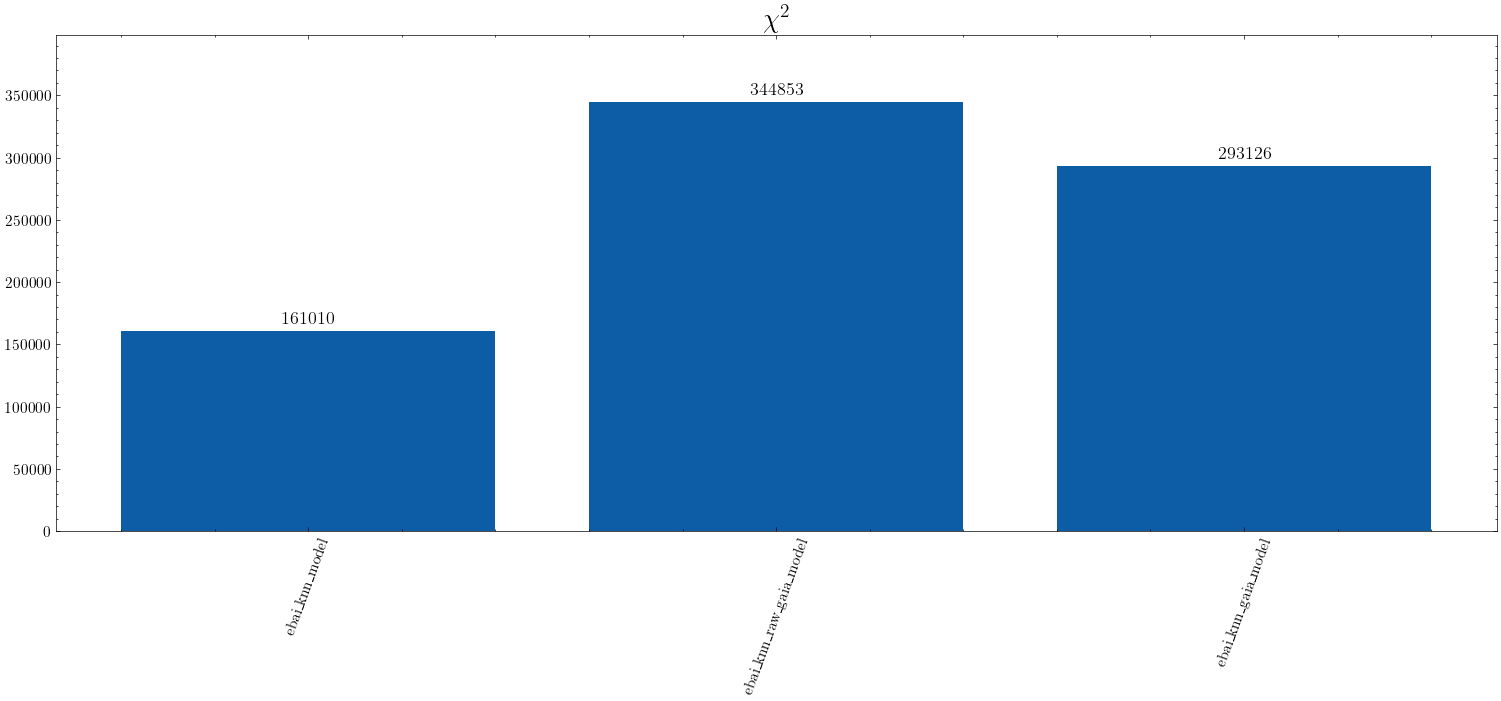

In [24]:
import scienceplots
plt.style.use("science")

_, ax = plt.subplots(layout='constrained', figsize=(15, 7))
# rects = ax.bar(np.arange(len(b.models)), list(map(lambda m: b.calculate_chi2(model=m, dataset=allRawDatasets + normalizedDatasets), b.models)))
rects = ax.bar(np.arange(len(b.models)), list(map(lambda m: b.calculate_chi2(model=m, dataset=allRawDatasets), b.models)))
ax.bar_label(rects, padding=3, size=13)
ax.set_xticks(np.arange(len(b.models)), b.models, rotation=70)
ax.tick_params(axis='both', labelsize=11)
ax.set_title(r"$\chi^2$", size=20)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymax=ymax + (0.1*ymax))

In [25]:
print("\nall normalized\n----------------------------")
gen_utils.printFittedVals(b, 'ebai_knn_solution')
print("Datasets:", b['value@ebai_knn@lc_datasets'])

# print("\nall raw (ebai_knn_raw)\n----------------------------")
# gen_utils.printFittedVals(b, 'ebai_knn_raw_solution')
# print("Datasets:", b['value@ebai_knn_raw@lc_datasets'])

# print("\nGaia RP raw (ebai_knn_lc_gaia_rp_raw)\n----------------------------")
# gen_utils.printFittedVals(b, 'ebai_knn_lc_gaia_rp_raw_solution')
# print("Datasets:", b['value@ebai_knn_lc_gaia_rp_raw@lc_datasets'])

# print("\nlc_iturbide\n----------------------------")
# gen_utils.printFittedVals(b, 'ebai_knn_lc_iturbide_solution')
# print("Datasets:", b['value@ebai_knn_lc_iturbide@lc_datasets'])

# print("\nlc_iturbide_raw\n----------------------------")
# gen_utils.printFittedVals(b, 'ebai_knn_lc_iturbide_raw_solution')
# print("Datasets:", b['value@ebai_knn_lc_iturbide_raw@lc_datasets'])


all normalized
----------------------------
t0_supconj@binary@orbit@component = 0.14901 d
teffratio@binary@orbit@component = 0.91419 
incl@binary@orbit@component = 1.10287 rad
fillout_factor@contact_envelope@envelope@component = 0.29972 
q@binary@orbit@component = 0.83674 
Datasets: ['lc_iturbide', 'lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp']


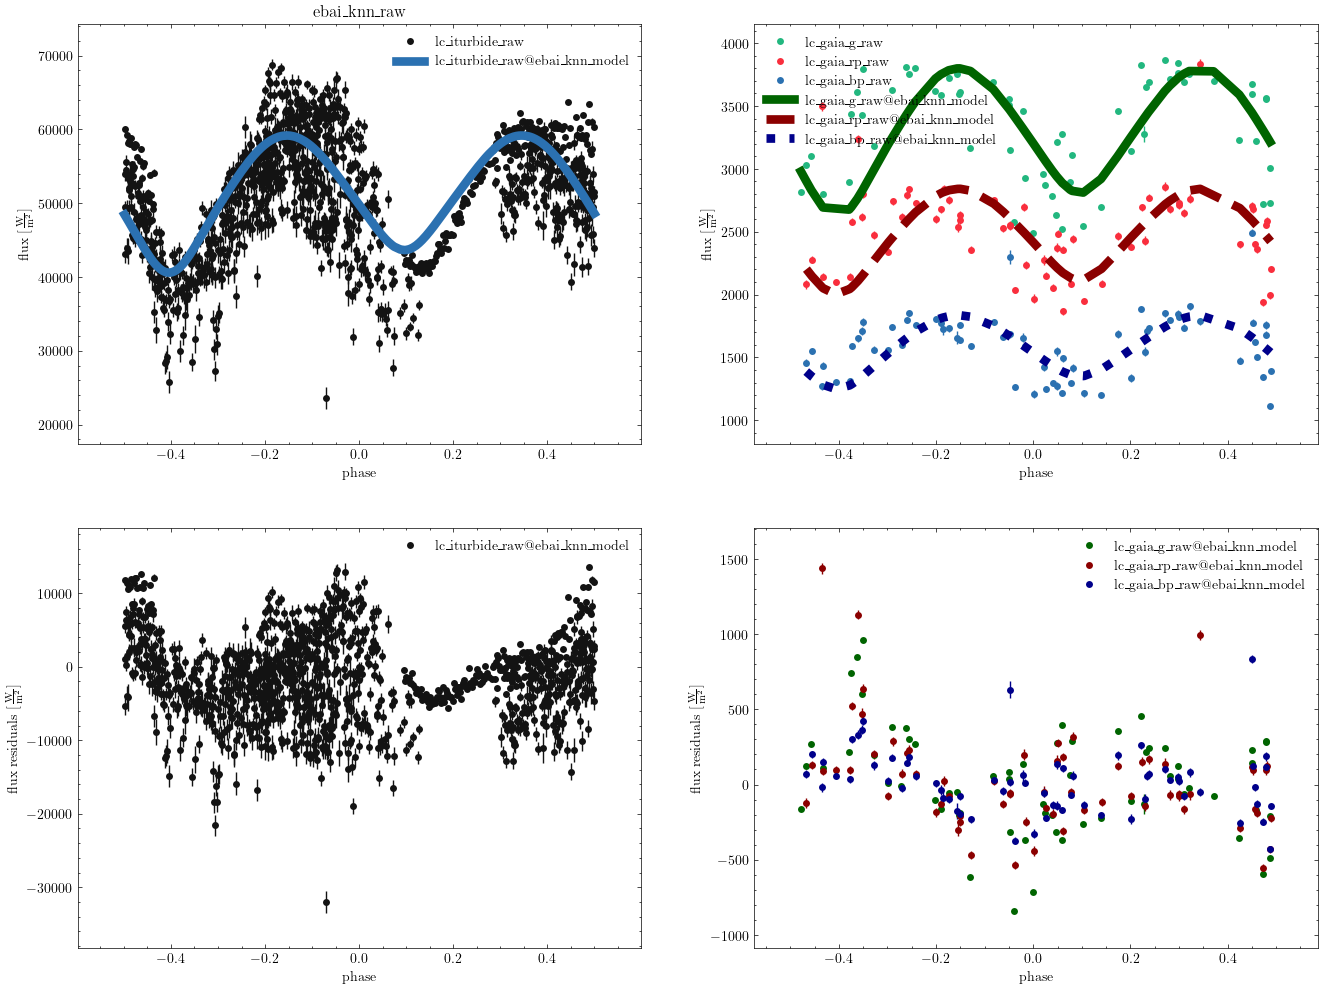

(<autofig.figure.Figure | 4 axes | 12 call(s)>,
 <Figure size 1600x1200 with 4 Axes>)

In [27]:
# model = "ebai_knn_raw_model"
model = "ebai_knn_model"

b.plot(x='phase', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, title=solver, axorder=1)
b.plot(x='phase', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=2, color=gen_utils.GAIA_RAW_PLOT_COLORS)

b.plot(x='phase', y='residuals', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker='.', s=0.008, axorder=3)
b.plot(x='phase', y='residuals', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, show=True, marker='.', s=0.008, draw_title=True, axorder=4, subplot_grid=(2,2), save=f"./graphs/raw_only/ebai/{solver}", color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [28]:
# b.adopt_solution('ebai_knn_raw_solution')
b.adopt_solution('ebai_knn_solution')

<ParameterSet: 40 parameters | contexts: dataset, component>

## Save estimator bundle

In [29]:
# gen_utils.saveBundle(b, "ebai-estimates")
gen_utils.saveBundle(b, "ebai-estimates", "comp-LID3")
# gen_utils.saveBundle(b, "ebai-solver-runs-no-estimates")

'bundle-saves/comp-LID3/ebai-estimates'

## Trimming Bundle
Dropping unused datasets, as well as cleaning up models that won't be used in future steps

In [31]:
# dropping normalized datasets
normDatasets = [d for d in b.datasets if 'raw' not in d and d != 'mesh01']
b.remove_dataset(normDatasets)
b.datasets

['mesh01',
 'lc_iturbide_raw',
 'lc_gaia_g_raw',
 'lc_gaia_rp_raw',
 'lc_gaia_bp_raw']

In [32]:
# removing unused models (all of them until now)
b.remove_model(b.models)

<ParameterSet: 531 parameters | contexts: model, figure>

In [33]:
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed')
gen_utils.saveBundle(b, 'ebai-estimates-trimmed', "comp-LID3")

'bundle-saves/comp-LID3/ebai-estimates-trimmed'